In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
SEED=999

# Problem 1
## Setting up the Graph

['o', 'a', 'b', 'c', 'd']


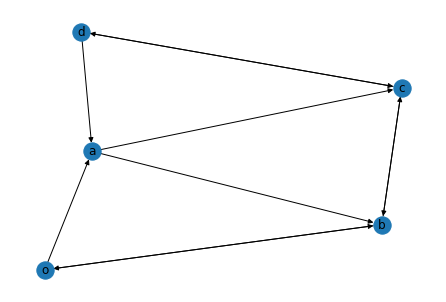

In [ ]:
%matplotlib inline
G=nx.DiGraph()
G.add_nodes_from(["o","a","b","c","d"])
print(G.nodes())
edges=[("o","b"),("o","a"),("b","o"),("b","c"),("a","b"),("a","c"),
       ("c","b"),("c","d"),("d","a"),("d","c")]
G.add_edges_from(edges)



pos=nx.spring_layout(G,seed=SEED)
nx.draw(G,pos,with_labels=True)
plt.show()


In [ ]:
nodeToIdx={"o":0,"a":1,"b":2,"c":3,"d":4}

A=[
    [0,2/5,1/5,0,0],
    [0,0,3/4,1/4,0],
    [1/2,0,0,1/2,0],
    [0,0,1/3,0,2/3],
    [0,1/3,0,1/3,0]
]

w = np.sum(A, axis=1)
w_star = np.max(w)
P_bar = A/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

print("Node of G:\n",G.nodes())
print("P_bar matrix:\n",P_bar)

Node of G:
 ['o', 'a', 'b', 'c', 'd']
P_bar matrix:
 [[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]


## Point a
What is, according to the simulations, the average time it takes a particle that starts in node
a to leave the node and then return to it?

We define a function that calculates the time taken by a single particle to start from a node and reach and ending node.

**Note:** the function can compute the simulated return time (starting and ending node is the same) and the simulated hitting time (starting and ending node are different)

In [ ]:
def particle_routing_time(start_node,end_node,w_start,Q):
    start_node_idx=nodeToIdx[start_node]
    end_node_idx=nodeToIdx[end_node]
    #set the number of steps of simulation
    n_steps=1000
    #pos keep the trace of the visited nodes
    pos=np.zeros(n_steps,dtype=int)
   
    pos[0]=start_node_idx #start from state 0 and node a in position 1

    transition_times=np.zeros(n_steps) #store the time for esch transition
    t_next= -np.log(np.random.rand())/w_star
    Q_cum=np.cumsum(Q,axis=1) #cumulative matrix of row of Q

    for i in range(1,n_steps):
        pos[i]=np.argwhere(Q_cum[pos[i-1]]>np.random.rand())[0]

        #store the time instant of the current transition
        transition_times[i]=transition_times[i-1]+t_next
        #recopute the waiting time of the next transition
        t_next=-np.log(np.random.rand()/w_star)

        #If the state come back to the original state stop
        if pos[i]==end_node_idx:
            #print("The state comes back to the origin in: ",transition_times[i])
            return transition_times[i]


Here we use that function multiple times since the walk is random and we want to find the average time.

In [ ]:
simNum=10000

time=0
for i in range(simNum):
    time+=particle_routing_time("a","a",w_star,P_bar)
avgTime=time/simNum
print("Average Time of",simNum,"simulation:",avgTime)

Average Time of 10000 simulation: 6.719469937339994


## Point b
How does the result in a) compare to the theoretical return-time Ea[T
+
a
]? (Include a description of how this is computed.)


In [ ]:
nx.components.is_strongly_connected(G)

True

Since the graph is strongly connected we can use Kac's formula adapted to continuous-time random walks

$$ E_{a}[T_{a}^{+}] =  \frac{1} {w_{a}\bar{\pi}_{a}}$$

where $\bar{\pi}$ is the invariant probability vector

In [ ]:
def return_time(start_node):
    
    eig_vals,eig_vecs=np.linalg.eig(P_bar.T)
    pi_bar=eig_vecs[:,np.argmax(eig_vals.real)].real
    pi_bar=pi_bar/np.sum(pi_bar) #normalization

   
    theo_ret_time=1/(w[nodeToIdx[start_node]]*pi_bar[nodeToIdx[start_node]])
    return theo_ret_time

print("Theoretical return time in a:",return_time("a"))


Theoretical return time in a: 6.749999999999999


## Point d

NOTE: point d is here because we generalize the function that analyze the convergence 

How does the result in c) compare to the theoretical hitting-time Eo[Td]?

To compute the theoretical value, we use the recursive formula for the return times extended to generic  o  (origin node) and  d  (destination node):

$$E_{o}[T_{d}]=\frac{1} {w_{∗}}+∑_{j}P_{o,j}E_{j}[T_{d}]$$
 
with  $E_{d}[T_{d}]=0$ .

In [ ]:
def hitting_time(start_node,end_node):
    start_idx=nodeToIdx[start_node]
    R = [list(G.nodes()).index(node) for node in list(G.nodes()) if node != end_node]
    # calculating the expected hitting times for the other nodes
    # the recursive formula can be solved through a linear matrix equation
    degrees = np.sum(A,axis=1)
    D = np.diag(degrees)
    P = np.linalg.inv(D) @ A
    P_hat = P[np.ix_(R, R)]

    exp_hitting_times_R = np.linalg.solve((np.identity(P_hat.shape[start_idx]) - P_hat), np.ones(P_hat.shape[start_idx])/w_star)

    exp_hitting_times = np.zeros(len(list(G.nodes())))
    exp_hitting_times[R] = exp_hitting_times_R
    exp_od_time = exp_hitting_times[start_idx]
   
    return exp_od_time

print(f"Expected time to go from o to d:",hitting_time("o","d"))



Expected time to go from o to d: 7.357142857142856


## Point c

What is, according to the simulations, the average time it takes to move from node o to node
d?

In [ ]:
def analyze_convergence(start_node,end_node,w_star,Q,with_plot=True,tol=10e-6):
    
    times=[]
    times.append(particle_routing_time(start_node,end_node,w_star,Q))
    avgTimes=[]
    avgTimes.append(times[-1])

    #In case of return simulation
    if start_node==end_node:
        theo_time=return_time(start_node)
        print("Simulation 1, theoretical return time vs simulation return time: ",f"{theo_time:.6f}","vs",f"{np.average(avgTimes):.6f}")
    else:
        #in case of hitting simulation
        theo_time=hitting_time(start_node,end_node)
        print("Simulation 1, theoretical hitting time vs simulation hitting time: ",f"{theo_time:.6f}","vs",f"{np.average(avgTimes):.6f}")

    if with_plot:
        #%matplotlib notebook in colab interactive gigure are not avalaible
        %matplotlib inline
        fig=plt.figure(figsize=(10,5))
        ax = fig.add_subplot(111)
        plt.ion()

        fig.show()
        ax.plot(avgTimes)
        ax.plot(times)
        fig.canvas.draw()

    while (not np.isclose(theo_time,avgTimes[-1],tol)):
        
        times.append(particle_routing_time(start_node,end_node,w_star,Q))
        avgTimes.append(np.average(times))
        
        if with_plot:
            ax.clear()
            ax.set_title('Simulations')
            ax.set_xlabel('Number of simulations')
            #ax.set_ylabel('Time to return in a')
                   
            ax.scatter(range(len(times)),times,zorder=1)
            ax.plot(avgTimes,color="orange",zorder=0)
            
            ax.text(len(times)-1, times[-1], "Time: "+f"{times[-1]:.5f}")
            ax.text(len(avgTimes)-1, avgTimes[-1], "Avg: "+f"{avgTimes[-1]:.5f}")
            fig.canvas.draw()
        
    print(f"Converges after {len(avgTimes)} simulations with avg time: {avgTimes[-1]:.6f}")

In [ ]:
analyze_convergence("o","d",w_star,P_bar,with_plot=True,tol=10e-2)

Simulation 1, theoretical hitting time vs simulation hitting time:  7.357143 vs 9.645561


## Point a/b.2

We want to check the number of simulation needed to converge at the theoretical time
we use a tollerance

Simulation 1, theoretical return time vs simulation return time:  6.750000 vs 13.376197
Converges after 13 simulations with avg time: 6.817040


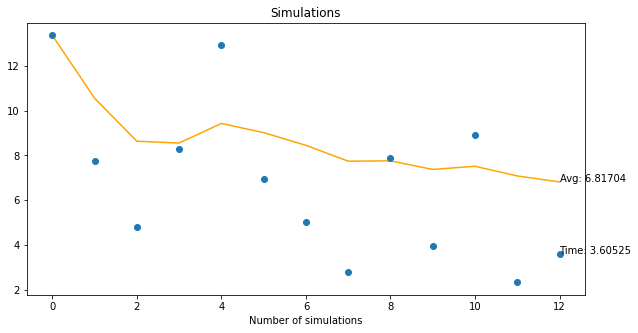

In [ ]:
analyze_convergence("a","a",w_star,P_bar,with_plot=True,tol=10e-3)

## Point e

Interpret the matrix Λ as the weight matrix of a graph G = (V, E,Λ), and simulate the French DeGroot dynamics on G with an arbitrary initial condition x(0). Does the dynamics converge
to a consensus state? Motivate your answer.

We need to check if graph is strongly connected (it is, already checked, controllare meglio se è sufficente o necessaria) and aperiodic (it is) if both conditions are checked, then:

$$\lim_{t \to +\infty} x(t) = \alpha \mathbf{1},$$

i.e., the agents get to consensus.


In [ ]:
nx.algorithms.is_aperiodic(G)

True

Starting opinion: [1. 0. 0. 0. 1.]


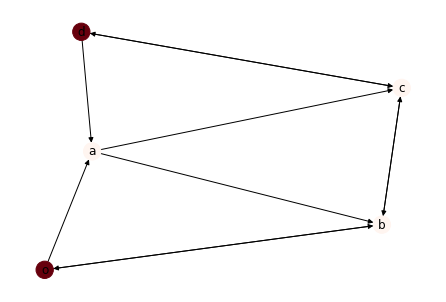

Opinion after 10 iteration: [0.30243699 0.29627218 0.31545782 0.29324203 0.31385031]


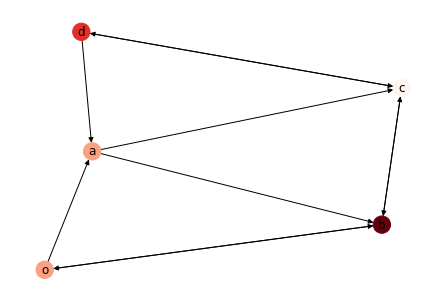

Opinion after 20 iteration: [0.30430793 0.30403942 0.3050493  0.30328399 0.3052297 ]


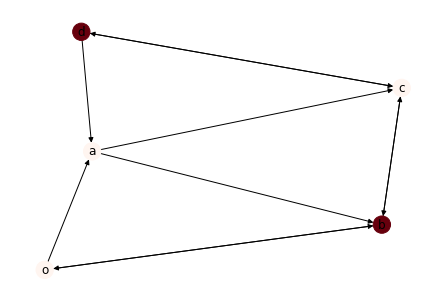

Opinion after 30 iteration: [0.30434659 0.30432125 0.30440423 0.30426118 0.30442069]


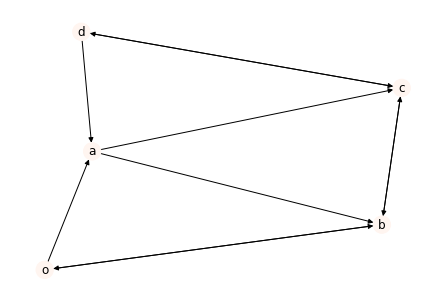

Opinion after 40 iteration: [0.30434772 0.30434566 0.30435242 0.30434079 0.30435374]


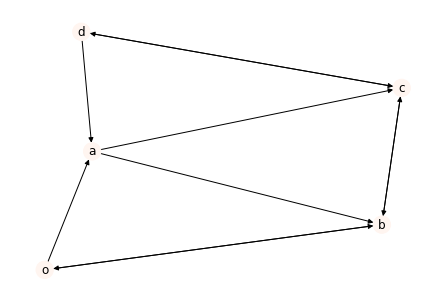

Opinion after 50 iteration: [0.30434782 0.30434765 0.3043482  0.30434725 0.30434831]


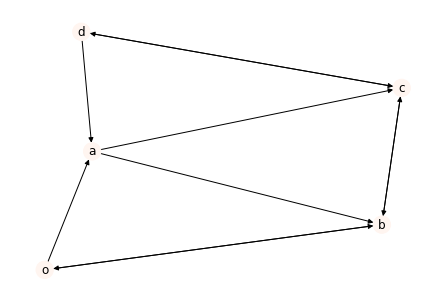

Opinion after 60 iteration: [0.30434783 0.30434781 0.30434786 0.30434778 0.30434787]


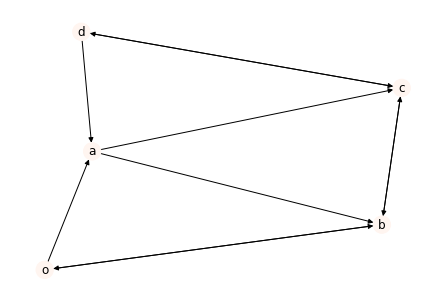

Opinion after 70 iteration: [0.30434783 0.30434782 0.30434783 0.30434782 0.30434783]


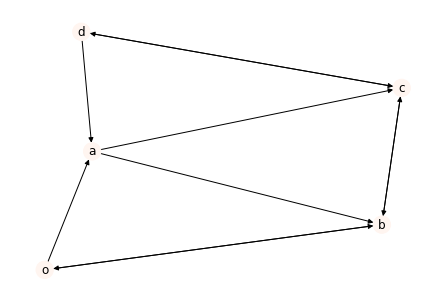

Opinion after 80 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


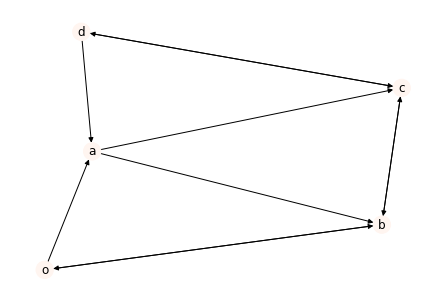

Opinion after 90 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


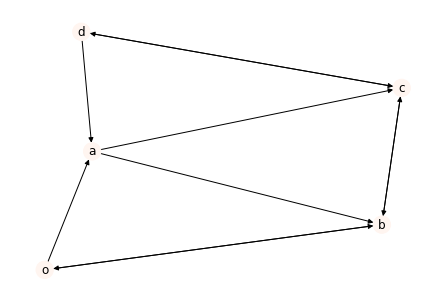

Opinion after 100 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


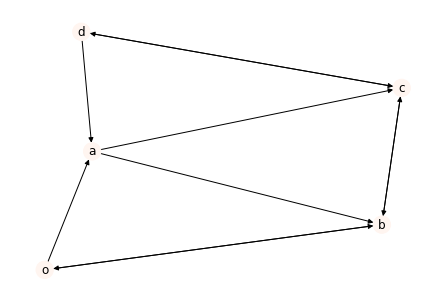

Opinion after 110 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


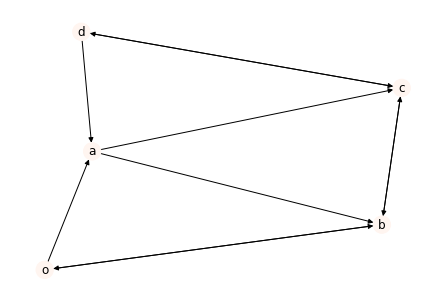

Opinion after 120 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


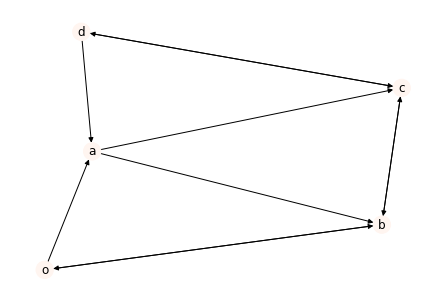

Opinion after 130 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


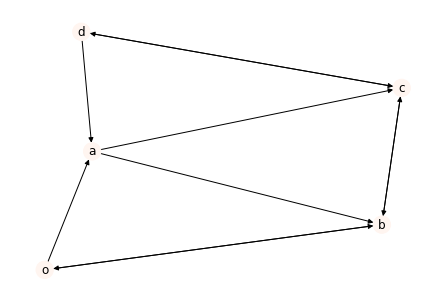

Opinion after 140 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


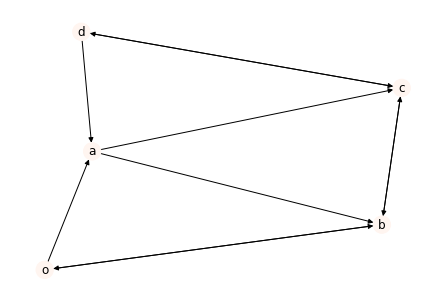

Opinion after 150 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


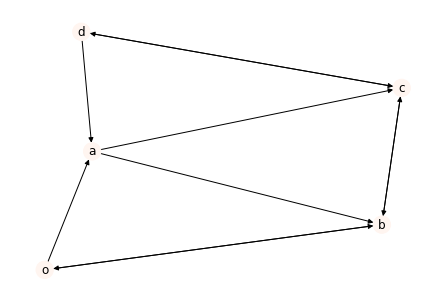

Opinion after 160 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


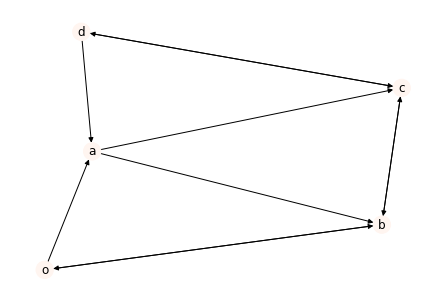

Opinion after 170 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


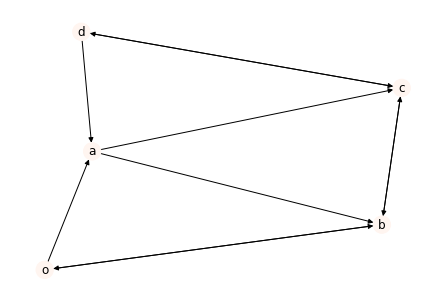

Opinion after 180 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


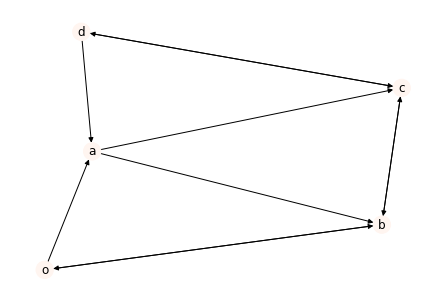

Opinion after 190 iteration: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


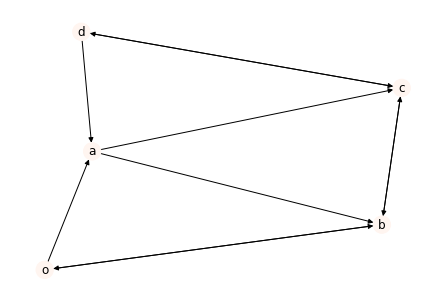

Ending opinion: [0.30434783 0.30434783 0.30434783 0.30434783 0.30434783]


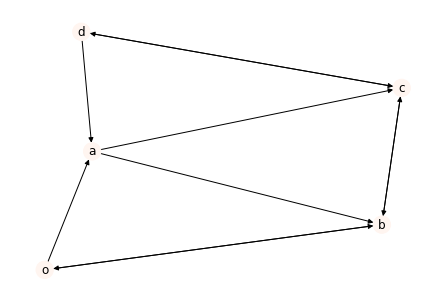

In [ ]:
def deGroot_dynamics(init_state,G,W,n_iter=200,printEvery=10):
  
  # Construct P  
  degrees = np.sum(W,axis=1)
  D = np.diag(degrees)
  P = np.linalg.inv(D) @ W

  # keep track of the trajectory
  x = np.zeros((n_iter,len(G.nodes())))

  # set initial condition 
  x[0]=init_state

  print("Starting opinion:",x[0])
  nx.draw(G,pos,node_color=np.round(x[0], decimals=2)*100,with_labels=True, cmap=plt.cm.Reds)
  plt.show()

  # evolve the states
  for t in range(1,n_iter):
      x[t] = P @ x[t-1]
      if t%(printEvery)==0:
        print("Opinion after",t,"iteration:",x[t])
        nx.draw(G,pos,node_color=np.round(x[t], decimals=2)*100,with_labels=True, cmap=plt.cm.Reds)
        plt.show()

  print("Ending opinion:",x[-1])
  nx.draw(G,pos,node_color=np.round(x[-1], decimals=2)*100,with_labels=True, cmap=plt.cm.Reds)
  plt.show()
  return x

x=deGroot_dynamics([1,0,0,0,1],G,np.array(A),printEvery=10)

Since the graph is strongly connected and aperiodic we can note that the opinion converge to a consensus.

## Consensus value

How is the consensus value computed?

Let $\pi$ denote the normalized left dominant eigenvector of $P$, i.e., the normalized $\pi$ such that $P' \pi = \pi$ (which is unique because the graph has one sink only).
We use the fact that

$$\pi' x(t) = \pi' P x(t-1) = \pi' x(t-1),$$

thus $\pi' x(t)$ is constant along the dynamics. Thus,

$$\pi' x(0) = \pi' \lim_{t \to + \infty} x(t) = \alpha \pi' \mathbf{1} =\alpha$$

Thie computation above says that the consensus value $\alpha$ is the weighted average of the initial conditions of the nodes, where the weights are given by the (unique) invariant distribution $\pi$.

Recall that $\pi$ solving $\pi = P' \pi$ is also the invariant distribution centrality, thus the more a node is central the more its initial opinion affects the consensus value.

In [ ]:
def consensus_value(G,W,states):
  #Note: states contains the opinions vectors of each iteration of degroot_dynamics
  # Construct P to compute eigenvalue and eigenvector
  degrees = np.sum(W,axis=1)
  D = np.diag(degrees)
  P = np.linalg.inv(D) @ W
  w,v = np.linalg.eig(P.T)

  # selects the eigenvalue 1 and save the eigenvector
  for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
      pi = v[:,index].real  # convert eigenvector to real
      pi = pi/np.sum(pi)
      
  print("Theoretical convergence opinion:",pi.T@states[0]) 
  print("Numerical avg of nodes opinion:",np.average(states[-1]))

consensus_value(G,np.array(A),x)

Theoretical convergence opinion: 0.3043478260869566
Numerical avg of nodes opinion: 0.30434782608695554


## Point f

 Assume that the initial state of the dynamics for each node i ∈ V is given by $$x_{i}(0) = ξ_{i}$$
where $ξ_{i}$ i∈V are i.i.d random variables with variance $\sigma^2$.
Compute the variance of the consensus value, and compare your results with numerical simulations.

The variance of the consensus value can be computed as follow:
$$\sigma_{consensus}^2 = \sigma^2 \sum_{i} \pi_i^2 < \sigma^2$$

Note: the variance of the consensus value is less than the variance of the node state (the crowd is wiser than the single).

In [ ]:
#Return the thoretical variance of the consensus value.
def theo_var_cons_value(G,W,var):
  # Construct P
  degrees = np.sum(W,axis=1)
  D = np.diag(degrees)
  P = np.linalg.inv(D) @ W
  w,v = np.linalg.eig(P.T)

  # selects the eigenvalue 1 and print the eigenvector
  for index in [i for i in range(len(G)) if np.isclose(w[i],1)]: 
      pi = v[:,index].real  # -> eigenvectors are complex but pi is real, so we convert it to real
      pi = pi/np.sum(pi)

  
  return np.sum(pi**2)*var
theo_var_cons_value(G,np.array(A),1/12)

0.017800882167611845

Starting opinion: [0.59293355 0.13137788 0.04758634 0.0511661  0.09253855]


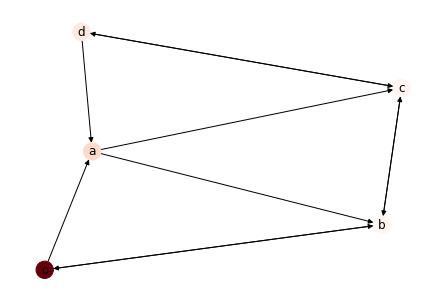

Ending opinion: [0.14204265 0.14204265 0.14204265 0.14204265 0.14204265]


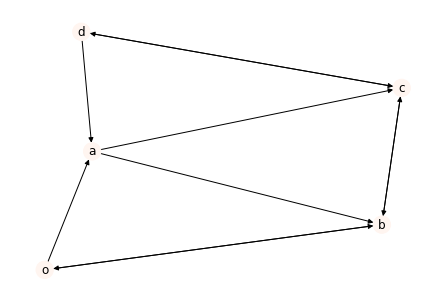

Theoretical convergence opinion: 0.1420426524328638
Numerical avg of nodes opinion: 0.14204265243286335


In [ ]:
#Simulate degroot dynamics with random uniform distributed intial state
init_state=np.random.rand(G.number_of_nodes())#Uniform distribution between [0-1] variance 1/12

x=deGroot_dynamics(init_state,G,np.array(A),printEvery=200)
consensus_value(G,np.array(A),x) #the conesensus is reached

In [ ]:
#Reproduce degroot dynamics and save the variance
n_sim=200
n_states=500
W = np.array(A) # -> return type is scipy.sparse.csr_matrix

degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

# start with random initial states and run the dynamics
alfa_err = np.zeros(n_sim)
vars=[]
for i in range(n_sim):
# rand returns random values in [0,1], thus \mu = 1/2
    x = np.random.rand(len(G.nodes()))
    vars.append(np.var(x))
    for n in range(n_states):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))

#Qui notiamo che la varianza della folla è minore della varianza dei singoli nodi 
#Confrontiamo la varianza calcolata con la simulazione numerica con quella data dalla formula
print("Numerical variance of the node states:", np.mean(vars))
print("Theoretical variance of the node states:", 1/12,"\n") #is the variance of the uniform distr btween 0 and 1
print("Numerical variance of the consensus state:", np.mean(alfa_err)) #E' la varianza della simulazione numerica
print("Theoretical variance of the conensus state",theo_var_cons_value(G,W,1/12))#E' la varianza teorica 1/12*sum (pi_i^2)

Numerical variance of the node states: 0.06586846749526373
Theoretical variance of the node states: 0.08333333333333333 

Numerical variance of the consensus state: 0.017763583269517554
Theoretical variance of the conensus state 0.017800882167611845


## Point g 
Remove the edges (d, a) and (d, c). Describe and motivate the asymptotic behaviour of the
dynamics. If the dynamics converges to a consensus state, how is the consensus value related
to the initial condition x(0)? Assume that the initial state of the dynamics for each node
i ∈ V is given by xi(0) = ξi, where {ξi}i∈V are i.i.d random variables with variance σ
2
.
Compute the variance of the consensus value. Motivate your answer.

{'o': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]
[[0.00000000e+00 4.00000000e-01 2.00000000e-01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.50000000e-01 2.50000000e-01
  0.00000000e+00]
 [5.00000000e-01 0.00000000e+00 0.00000000e+00 5.00000000e-01
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.33333333e-01 0.00000000e+00
  6.66666667e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e-05]]
False
True


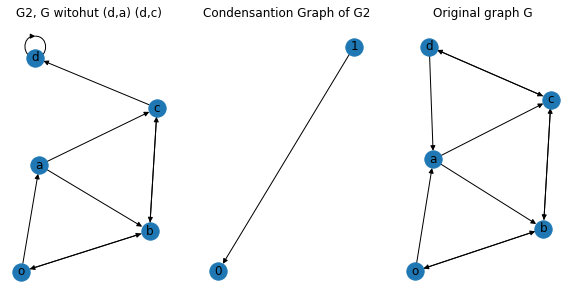

In [ ]:
G2=nx.DiGraph(G)
G2.remove_edge("d","a")
G2.remove_edge("d","c")
G2.add_edge("d","d") #design 



print(nodeToIdx)
A2=np.array(A)
A2[nodeToIdx["d"]][nodeToIdx["a"]]=0
A2[nodeToIdx["d"]][nodeToIdx["c"]]=0
A2[nodeToIdx["d"]][nodeToIdx["d"]]=0.00001 #Design problem the D matrix is singular adding a self loop in d resolve the problem(??)
print(np.array(A))
print(A2)

print(nx.algorithms.is_strongly_connected(G2)) #Not anymore strongly connected
print(nx.algorithms.is_aperiodic(G2)) #Still aperiodic
CG = nx.algorithms.components.condensation(G2)

fig=plt.figure(1,figsize=(10,5))
ax1=fig.add_subplot(1,3,1)
ax1.set_title("G2, G witohut (d,a) (d,c)")
ax2=fig.add_subplot(1,3,2)
ax2.set_title("Condensantion Graph of G2")
ax3=fig.add_subplot(1,3,3)
ax3.set_title("Original graph G")

nx.draw(G2,pos=pos,ax=ax1,with_labels=True)
nx.draw(CG,ax=ax2,with_labels=True)#We have only one sink
nx.draw(G,pos=pos,ax=ax3,with_labels=True)

Starting opinion: [1. 1. 1. 1. 2.]


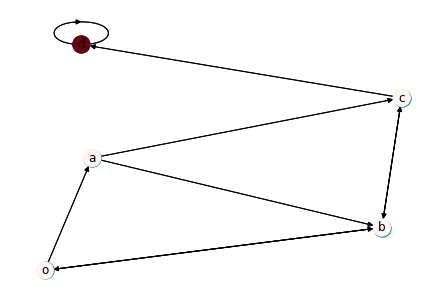

Opinion after 10 iteration: [1.80208333 1.83513374 1.84117798 1.93544239 2.        ]


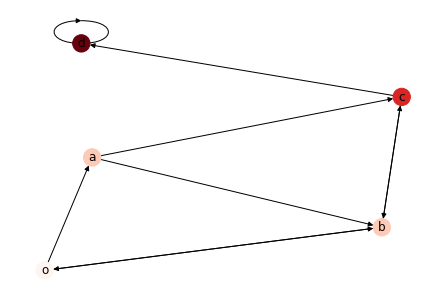

Opinion after 20 iteration: [1.97169024 1.97643298 1.97720408 1.9907711  2.        ]


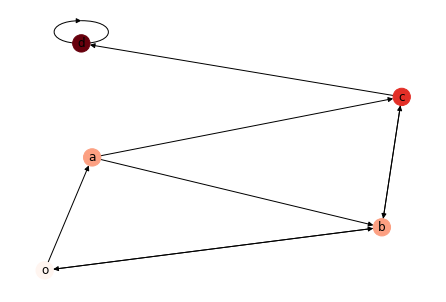

Opinion after 30 iteration: [1.99594592 1.9966252  1.99673558 1.99867843 2.        ]


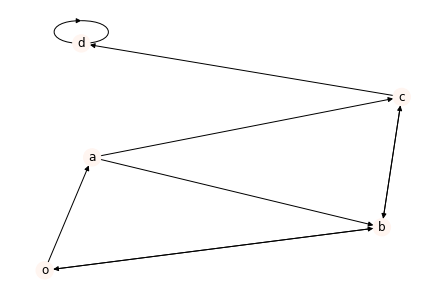

Opinion after 40 iteration: [1.99941945 1.99951672 1.99953253 1.99981075 2.        ]


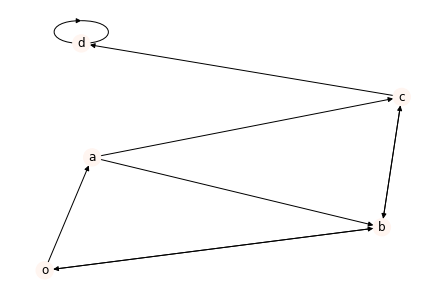

Opinion after 50 iteration: [1.99991686 1.99993079 1.99993306 1.9999729  2.        ]


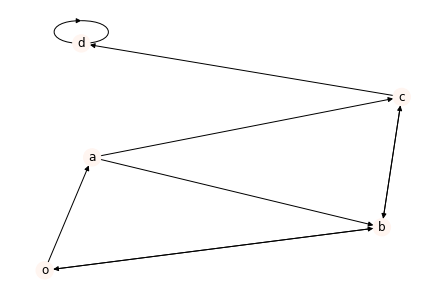

Opinion after 60 iteration: [1.99998809 1.99999009 1.99999041 1.99999612 2.        ]


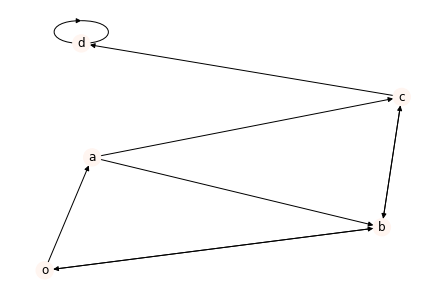

Opinion after 70 iteration: [1.9999983  1.99999858 1.99999863 1.99999944 2.        ]


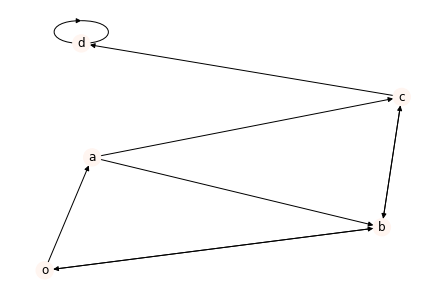

Opinion after 80 iteration: [1.99999976 1.9999998  1.9999998  1.99999992 2.        ]


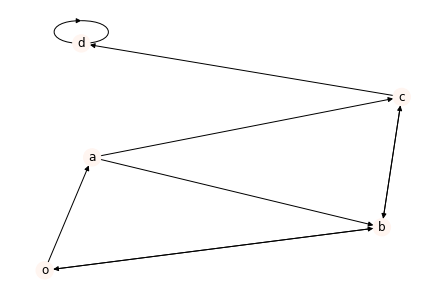

Opinion after 90 iteration: [1.99999997 1.99999997 1.99999997 1.99999999 2.        ]


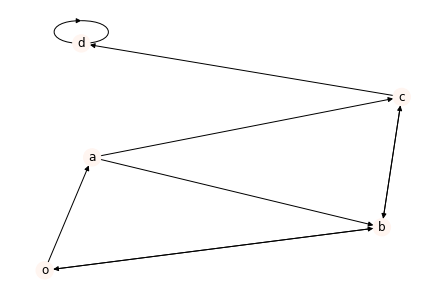

Opinion after 100 iteration: [1.99999999 2.         2.         2.         2.        ]


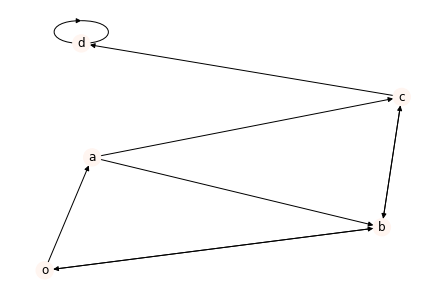

Opinion after 110 iteration: [2. 2. 2. 2. 2.]


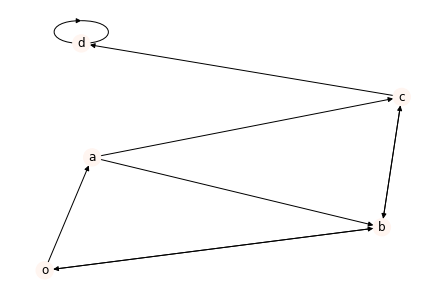

Opinion after 120 iteration: [2. 2. 2. 2. 2.]


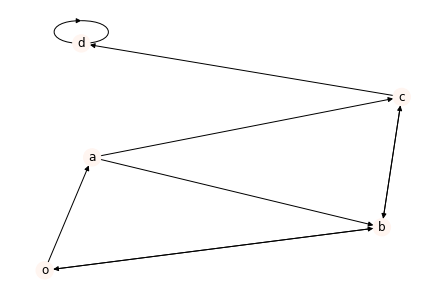

Opinion after 130 iteration: [2. 2. 2. 2. 2.]


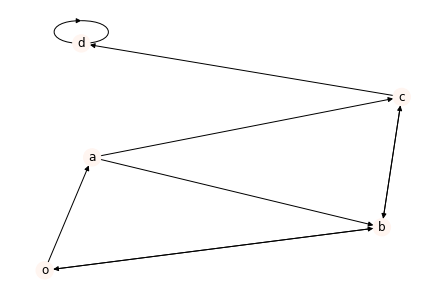

Opinion after 140 iteration: [2. 2. 2. 2. 2.]


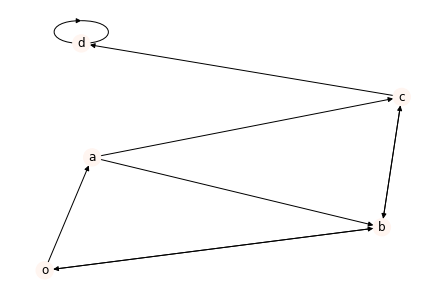

Opinion after 150 iteration: [2. 2. 2. 2. 2.]


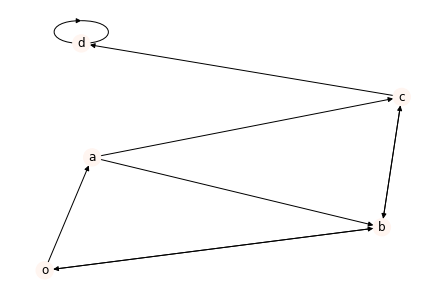

Opinion after 160 iteration: [2. 2. 2. 2. 2.]


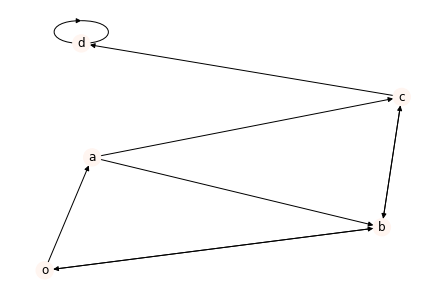

Opinion after 170 iteration: [2. 2. 2. 2. 2.]


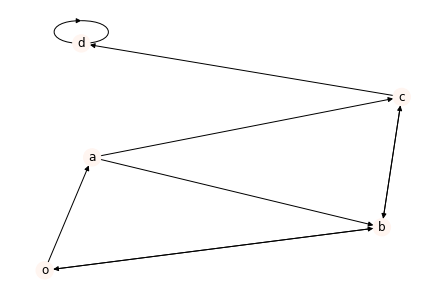

Opinion after 180 iteration: [2. 2. 2. 2. 2.]


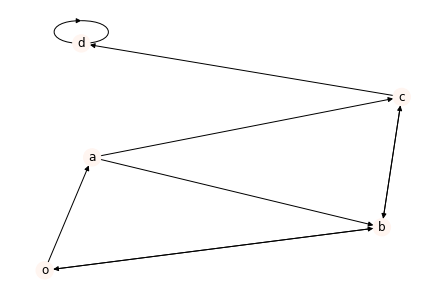

Opinion after 190 iteration: [2. 2. 2. 2. 2.]


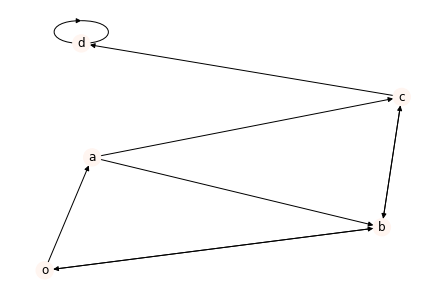

Ending opinion: [2. 2. 2. 2. 2.]


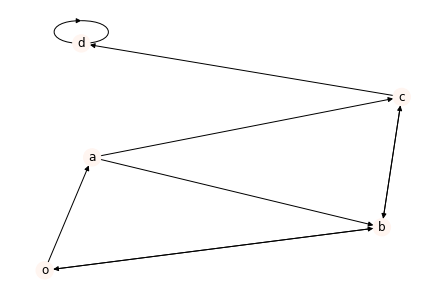

Theoretical convergence opinion: 2.0
Numerical avg of nodes opinion: 1.9999999999999567
Starting opinion: [1. 5. 2. 3. 0.]


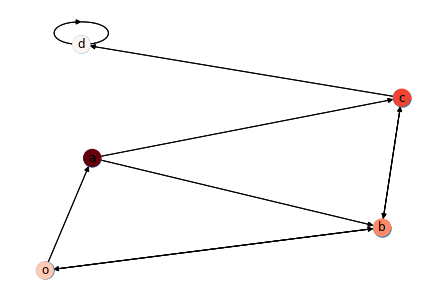

Opinion after 10 iteration: [0.50739455 0.42102302 0.41062243 0.16480195 0.        ]


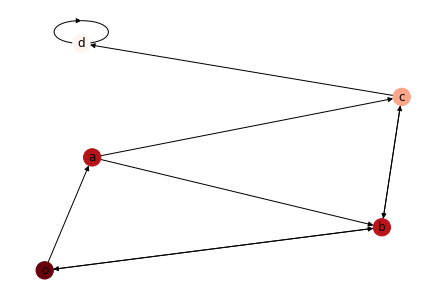

Opinion after 20 iteration: [0.07272691 0.06053859 0.05855888 0.02370658 0.        ]


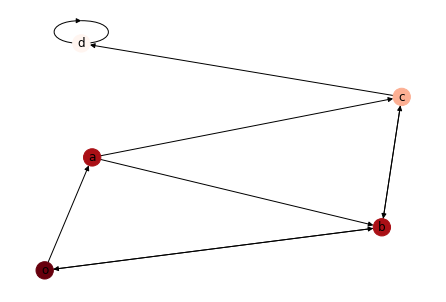

Opinion after 30 iteration: [0.01041432 0.00866935 0.0083858  0.00339491 0.        ]


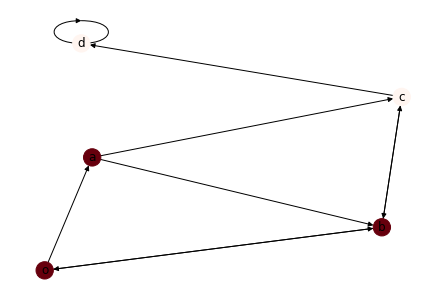

Opinion after 40 iteration: [0.00149135 0.00124147 0.00120086 0.00048616 0.        ]


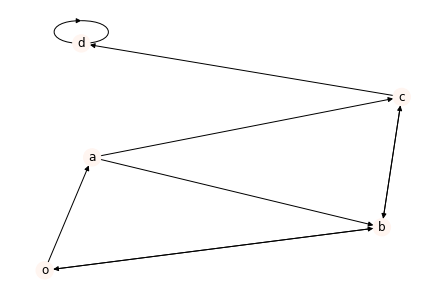

Opinion after 50 iteration: [2.13564084e-04 1.77780404e-04 1.71965758e-04 6.96186922e-05
 0.00000000e+00]


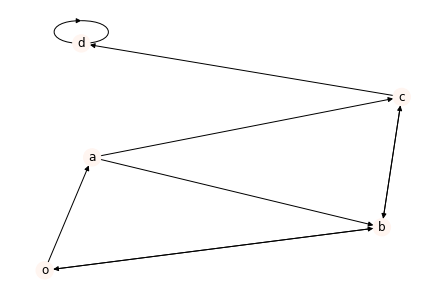

Opinion after 60 iteration: [3.05827714e-05 2.54584823e-05 2.46258142e-05 9.96952535e-06
 0.00000000e+00]


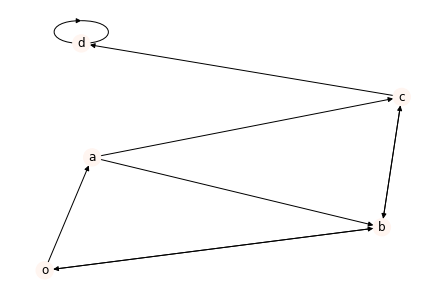

Opinion after 70 iteration: [4.37950938e-06 3.64570170e-06 3.52646210e-06 1.42765445e-06
 0.00000000e+00]


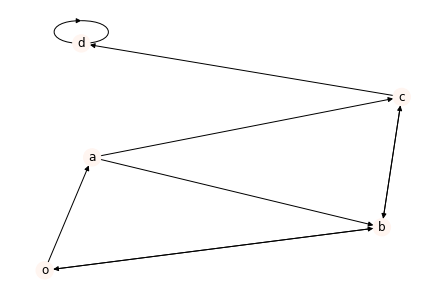

Opinion after 80 iteration: [6.27153835e-07 5.22071220e-07 5.04995888e-07 2.04442755e-07
 0.00000000e+00]


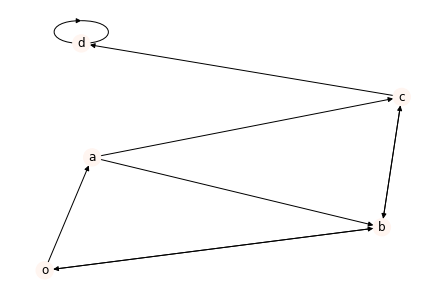

Opinion after 90 iteration: [8.98095879e-08 7.47615633e-08 7.23163443e-08 2.92765803e-08
 0.00000000e+00]


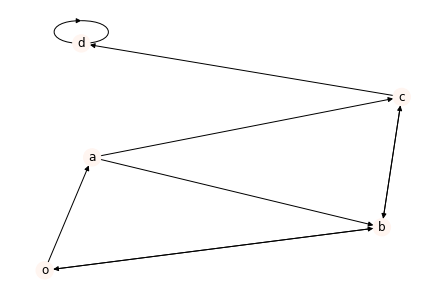

Opinion after 100 iteration: [1.28608989e-08 1.07059940e-08 1.03558341e-08 4.19246039e-09
 0.00000000e+00]


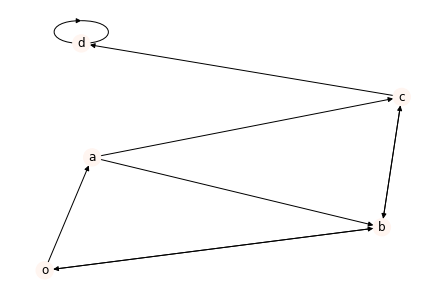

Opinion after 110 iteration: [1.84170449e-09 1.53311812e-09 1.48297458e-09 6.00368074e-10
 0.00000000e+00]


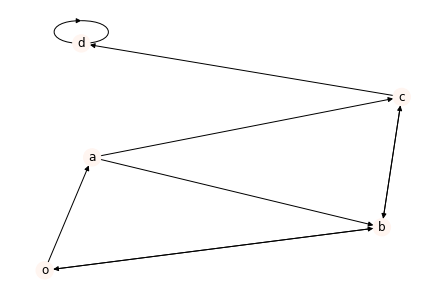

Opinion after 120 iteration: [2.63735486e-10 2.19545348e-10 2.12364700e-10 8.59738175e-11
 0.00000000e+00]


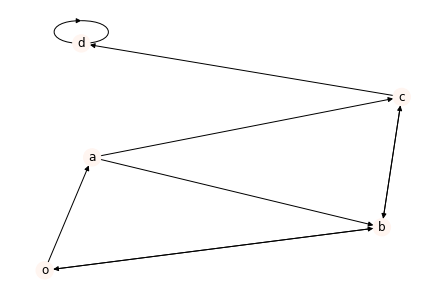

Opinion after 130 iteration: [3.77674089e-11 3.14392995e-11 3.04110174e-11 1.23116095e-11
 0.00000000e+00]


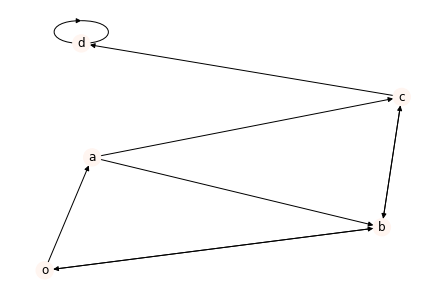

Opinion after 140 iteration: [5.40836273e-12 4.50216577e-12 4.35491388e-12 1.76304523e-12
 0.00000000e+00]


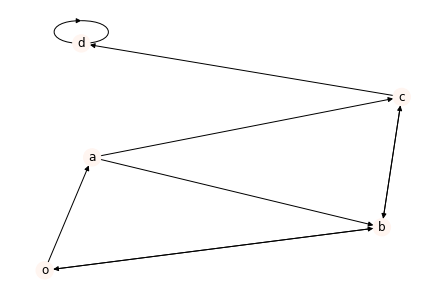

Opinion after 150 iteration: [7.74487536e-13 6.44718457e-13 6.23631715e-13 2.52471335e-13
 0.00000000e+00]


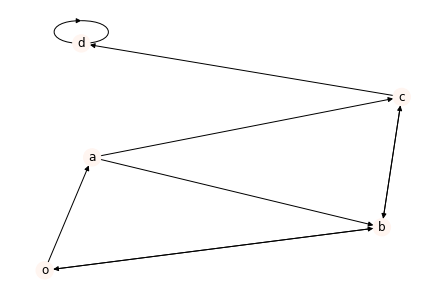

Opinion after 160 iteration: [1.10908046e-13 9.23248743e-14 8.93052138e-14 3.61543616e-14
 0.00000000e+00]


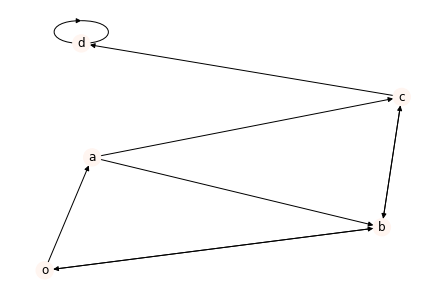

Opinion after 170 iteration: [1.58822371e-14 1.32210926e-14 1.27886716e-14 5.17737139e-15
 0.00000000e+00]


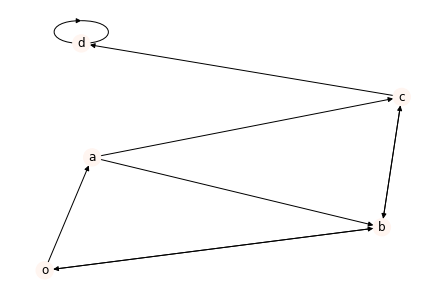

Opinion after 180 iteration: [2.27436570e-15 1.89328489e-15 1.83136141e-15 7.41409149e-16
 0.00000000e+00]


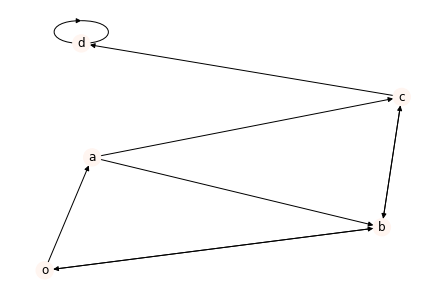

Opinion after 190 iteration: [3.25693371e-16 2.71121894e-16 2.62254337e-16 1.06171160e-16
 0.00000000e+00]


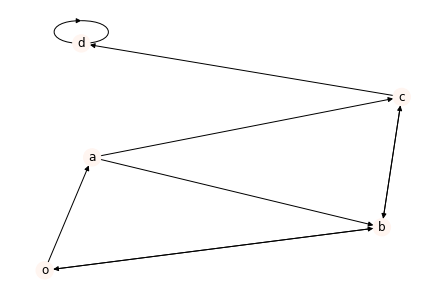

Ending opinion: [5.66451432e-17 4.71539794e-17 4.56117188e-17 1.84654681e-17
 0.00000000e+00]


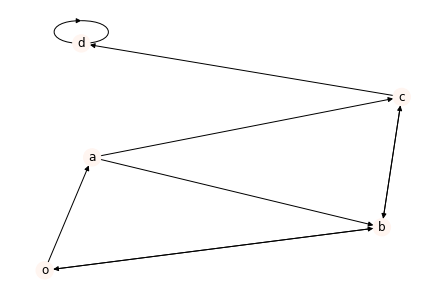

Theoretical convergence opinion: 0.0
Numerical avg of nodes opinion: 3.357526189479228e-17


In [ ]:
init_state=[1,1,1,1,2] #since d is the only sink the consensus value is the initial state of d (lab 5 cella numero 23)

nx.draw(G2,pos)
x=deGroot_dynamics(init_state,G2,A2,printEvery=10)
consensus_value(G2,A2,x) 

#Il valore di consenso è legato allo stato iniziale in base al fatto che l'opinione di "d" sarà il valore di consenso, questo credo perchè d è lunico sink
#il grafo resta aperiodico quindi si arriva al consenso però non è piu fortemente connesso

#Another example with different initial state 
init_state=[1,5,2,3,0] #since d is the only sink the consensus value is the initial state of d (lab 5 cella numero 23)

nx.draw(G2,pos)
x=deGroot_dynamics(init_state,G2,A2,printEvery=10)
consensus_value(G2,A2,x) 

In [ ]:
#Qui ricalcoliamo le varianze con il nuovo grafo
# Construct P
n_sim=200
n_states=500
W = np.array(A2) # -> return type is scipy.sparse.csr_matrix

degrees = np.sum(W,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ W

#Here we use a normal distribution with mu=0.5 and variance=10
mu=0.5
variance=10

# start with random initial states and run the dynamics
alfa_err = np.zeros(n_sim)
vars=[]
for i in range(n_sim):
    x=np.random.normal(loc=mu, scale=variance**(1/2), size=(1, len(G.nodes())))[0] #here we use a normal distribution
    vars.append(np.var(x))
    for n in range(n_states):
        x = P @ x
    alfa_err[i] = (1/2 - np.mean(x))*(1/2 - np.mean(x))

#In questo caso la varianza del consenso tende ad essere simile a quella dei singoli nodi
#credo perchè è solo il nodo d ad influenzare il consenso finale
print("Numerical variance of the node states:", np.mean(vars))
print("Theoretical variance of the node states:", variance,"\n")
print("Numerical variance of the consensus state:", np.mean(alfa_err))
print("Theoretical variance of the conensus state",theo_var_cons_value(G2,A2,variance))

Numerical variance of the node states: 8.116900280412
Theoretical variance of the node states: 10 

Numerical variance of the consensus state: 10.120848554436913
Theoretical variance of the conensus state 10.0


## Point h
Consider the graph (V, E,Λ), and remove the edges (c, b) and (d, a). Analyse the FrenchDeGroot dynamics on the new graph. In particular, describe and motivate the asymptotic
behaviour of the dynamics in terms of the initial condition x(0).

{'o': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4}
[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.        ]]
[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.66666667]
 [0.         0.         0.         0.33333333 0.        ]]
False
True


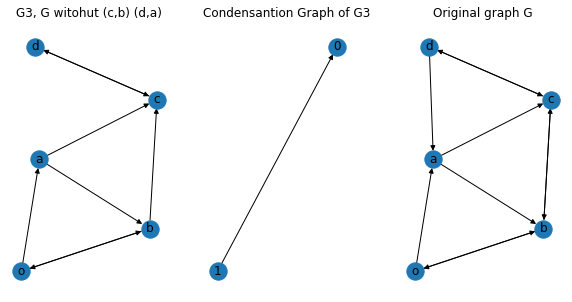

In [ ]:
G3=nx.DiGraph(G)
G3.remove_edge("c","b")
G3.remove_edge("d","a")



print(nodeToIdx)
A3=np.array(A)
A3[nodeToIdx["c"]][nodeToIdx["b"]]=0
A3[nodeToIdx["d"]][nodeToIdx["a"]]=0
print(np.array(A))
print(A3)

print(nx.algorithms.is_strongly_connected(G3)) #Not anymore strongly connected
print(nx.algorithms.is_aperiodic(G3)) #Still aperiodic
CG = nx.algorithms.components.condensation(G3)

fig=plt.figure(1,figsize=(10,5))
ax1=fig.add_subplot(1,3,1)
ax1.set_title("G3, G witohut (c,b) (d,a)")
ax2=fig.add_subplot(1,3,2)
ax2.set_title("Condensantion Graph of G3")
ax3=fig.add_subplot(1,3,3)
ax3.set_title("Original graph G")

nx.draw(G,pos=pos,ax=ax3,with_labels=True)
nx.draw(G3,pos=pos,ax=ax1,with_labels=True)
nx.draw(CG,ax=ax2,with_labels=True)#We have only one sink

In [ ]:
nodeToIdx

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'o': 0}

[[0.         0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.         0.         0.66666667]
 [0.         0.         0.         0.33333333 0.        ]]
Starting opinion: [1. 1. 1. 1. 3.]


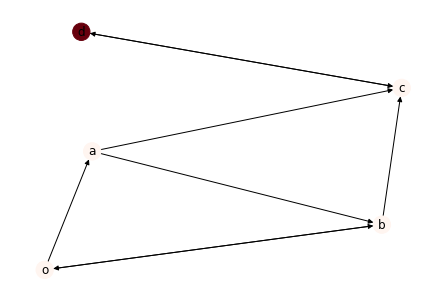

Ending opinion: [2.07692308 2.15384615 1.46153846 3.         1.        ]


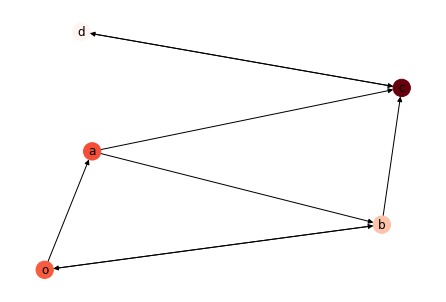

Theoretical convergence opinion: 1.9999999999999991
Numerical avg of nodes opinion: 1.9384615384615382
Starting opinion: [1. 1. 1. 1. 0.]


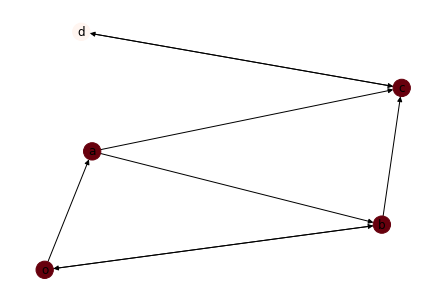

Ending opinion: [0.46153846 0.42307692 0.76923077 0.         1.        ]


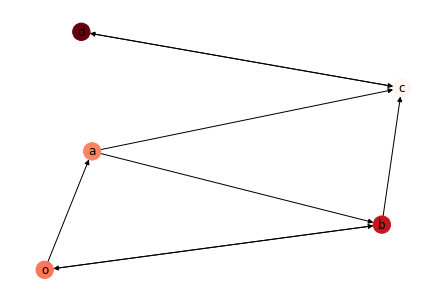

Theoretical convergence opinion: 0.5000000000000003
Numerical avg of nodes opinion: 0.5307692307692308
Starting opinion: [ 4.  2. -1. 10.  0.]


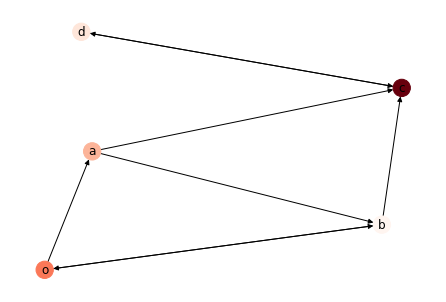

Ending opinion: [ 4.61538462  4.23076923  7.69230769  0.         10.        ]


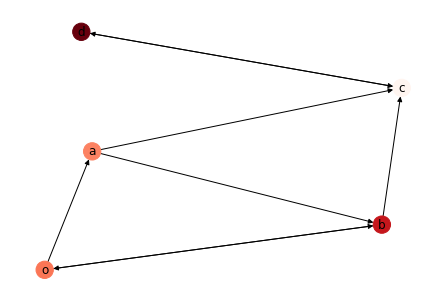

Theoretical convergence opinion: 4.999999999999998
Numerical avg of nodes opinion: 5.307692307692307


In [ ]:
print(A3)
init_state=[1,1,1,1,3]
x=deGroot_dynamics(init_state,G3,A3,printEvery=1000,n_iter=1000)
consensus_value(G3,A3,x)

init_state=[1,1,1,1,0]
x=deGroot_dynamics(init_state,G3,A3,printEvery=200)
consensus_value(G3,A3,x)

init_state=[4,2,-1,10,0]
x=deGroot_dynamics(init_state,G3,A3,n_iter=500,printEvery=500)
consensus_value(G3,A3,x)




# Problem 2

In [ ]:
degrees = np.sum(np.array(A),axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ np.array(A)
P_cum = np.cumsum(P, axis=1)
P_bar_cum = np.cumsum(P_bar, axis=1)

In [ ]:
print("Matrix P:\n",P)
print("Matrix P_cum:\n",P_cum)
print("Matrix P_bar:\n",P_bar)
print("Matrix P_bar_cum:\n",P_bar_cum)

Matrix P:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]
Matrix P_cum:
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.75       1.         1.        ]
 [0.5        0.5        0.5        1.         1.        ]
 [0.         0.         0.33333333 0.33333333 1.        ]
 [0.         0.5        0.5        1.         1.        ]]
Matrix P_bar:
 [[0.4        0.4        0.2        0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.33333333 0.         0.33333333 0.33333333]]
Matrix P_bar_cum:
 [[0.4        0.8        1.         1.         1.        ]
 [0.     

## Particle perspective

If 100 particles all start in node a, what is the average time for a particle to return to
node a?


For this simulation, we will use the approach involving the use of a Poisson clock with rate $w_i$ for
every node i in our state space, $\forall i \in X$.

In [ ]:
steps = 500
particles = 100
t_next = -np.log(np.random.rand())/w[1]
return_time = np.zeros(particles)
for j in range(0, particles):
  end = False
  pos = np.zeros(steps, dtype=int)
  pos[0] = 1 # node 1 -> 'a'
  transition_times = np.zeros(steps)
  for i in range(1,steps):
    if end==False:
      pos[i] = np.argwhere(P_cum[pos[i-1]] > np.random.rand())[0]
      transition_times[i] = transition_times[i-1] + t_next
      t_next = -np.log(np.random.rand())/w[pos[i]]
      if i != 1 and pos[i] == 1: #the particle is in node 'a' after exiting from it
        end = True
    else:
      break
  return_time[j] = transition_times[i-1]
avg_return_time = np.mean(return_time)
print("Average return time: {} s".format(avg_return_time))

Average return time: 6.777172128052231 s


How does this compare to the answer in Problem 1, why?


All the particles are independent and identically distributed, so simulating a random walk with
100 particles is equal to simulating a random walk with one particle 100 times. So this simulation
is equal to the one reported in point 1.A expect for the number of simulations. Here the number
of simulations is equal to the number of particles (100).

## Node perspective

If 100 particles start in node o, and the system is simulated for 60 time units, what is
the average number of particles in the different nodes at the end of the simulation?

For this simulation, we will use a global Poisson clock with rate 100 as the number of particles in
the system.

In [ ]:
w_star = 100
steps = 10000
particles = 100
nodes = len(G.nodes)
t_next = -np.log(np.random.rand())/w_star
pos = np.zeros((steps, nodes), dtype=int)
pos[0,0] = particles
transition_times = np.zeros(steps)
i=1
while transition_times[i-1] <= 60:
  node = np.random.choice(5, p=pos[i-1,:]/100)
  next_node = np.argwhere(P_bar_cum[node] > np.random.rand())[0]
  # copy past state
  pos[i,:] = pos[i-1,:]
  # node lose one particle
  pos[i,node] = pos[i,node]-1
  # next node gain one particle
  pos[i,next_node] = pos[i,next_node]+1
  transition_times[i] = transition_times[i-1] + t_next
  t_next = -np.log(np.random.rand())/w_star
  i+=1

In [ ]:
pos[i-1].mean()

20.0

Illustrate the simulation above with a plot showing the number of particles in each node
during the simulation time.

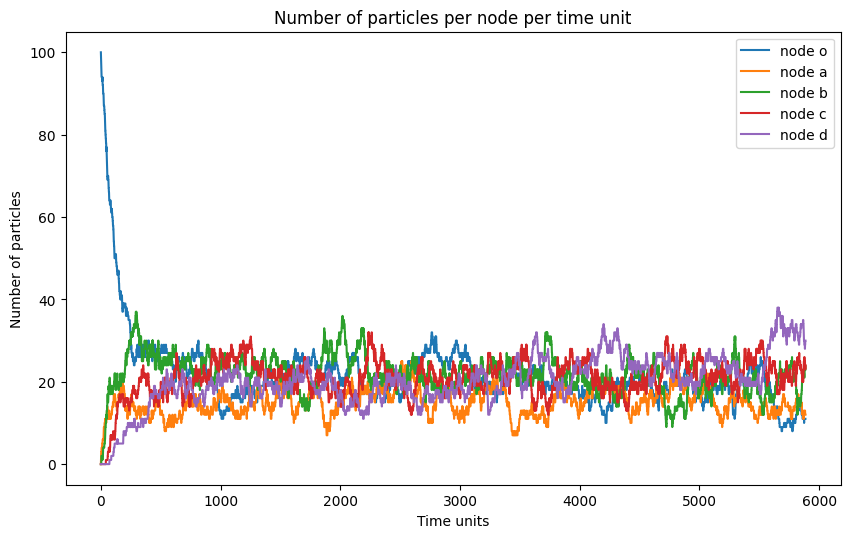

In [ ]:
end = i
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.subplot(111)
array = ['o', 'a', 'b', 'c', 'd']
for node in range(nodes):
  trajectory = pos[:end,node]
  ax.plot(trajectory, label='node {}'.format(array[node]))
ax.set_title("Number of particles per node per time unit")
ax.set_xlabel("Time units")
ax.set_ylabel("Number of particles")
ax.legend()

Compare the simulation result in the first point above with the stationary distribution of
the continuous-time random walk followed by the single particles.

The estimated result of this simulation should be equal to the invariant probability vector $π$ multiply
by 100, because the invariant probability vector contains the probabilities that a single particle
end up in each node.

In [ ]:
eig_vals,eig_vecs=np.linalg.eig(P_bar.T)
pi_bar=eig_vecs[:,np.argmax(eig_vals.real)].real
pi_bar=pi_bar/np.sum(pi_bar)

In [ ]:
print("Particles per node at final step: ", pos[end-1,:])
print("Average number of particles in every node: ", 100*pi_bar)

Particles per node at final step:  [11 12 23 24 30]
Average number of particles in every node:  [18.51851852 14.81481481 22.22222222 22.22222222 22.22222222]


# Problem 3

## Setting up the graph

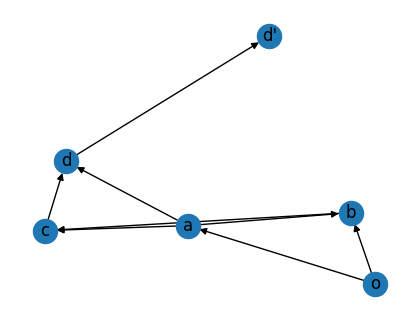

In [ ]:
G = nx.DiGraph()
G.add_node('o')
G.add_node('a')
G.add_node('b')
G.add_node('c')
G.add_node('d')
G.add_node("d'")
G.add_edges_from([('o', 'b'), ('o','a'), ('a','b'), ('a','c'), ('b', 'c'), ('a','d'), ('c', 'd'), ('d', "d'")])
pos = nx.spring_layout(G)
plt.figure(figsize=(4,3), dpi = 100)
nx.draw(G,pos, with_labels=True)

In [ ]:
lambda_matrix = np.array([
[0, 2/3, 1/3, 0, 0, 0],
[0, 0, 1/4, 1/4, 2/4, 0],
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[0, 0, 0, 0, 0, 0]]) # added node d'
w = np.sum(lambda_matrix, axis=1)
n_nodes = len(G.nodes)
w_star = np.max(w)
Q = lambda_matrix/w_star
Q = Q + np.diag(np.ones(len(w))-np.sum(Q,axis=1))
Q_cum = np.cumsum(Q, axis=1)

In [ ]:
print("Number of nodes: ", n_nodes)
print("\nVector w:\n", w)
print("\nMatrix D:\n", D)
print("\nMatrix P:\n", P)
print("\nMatrix P_cum:\n", P_cum)
print("\nMatrix Q:\n", Q)
print("\nMatrix Q_cum:\n", Q_cum)

Number of nodes:  6

Vector w:
 [1. 1. 1. 1. 1. 0.]

Matrix D:
 [[0.6        0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.66666667]]

Matrix P:
 [[0.         0.66666667 0.33333333 0.         0.        ]
 [0.         0.         0.75       0.25       0.        ]
 [0.5        0.         0.         0.5        0.        ]
 [0.         0.         0.33333333 0.         0.66666667]
 [0.         0.5        0.         0.5        0.        ]]

Matrix P_cum:
 [[0.         0.66666667 1.         1.         1.        ]
 [0.         0.         0.75       1.         1.        ]
 [0.5        0.5        0.5        1.         1.        ]
 [0.         0.         0.33333333 0.33333333 1.        ]
 [0.         0.5        0.5        1.         1.        ]]

Matrix Q:
 [[0.         0.66666667

## Proportional rate

The rate of the Poisson clock of each node is equal to the number of particles in it.
- Simulate the system for 60 time units and plot the evolution of the number of particles in each
node over time.
- What is the largest input rate that the system can handle without blowing up?

In [ ]:
def proportional_rate(input_rate):
  n_steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_p = -np.log(np.random.rand())/input_rate
  pos = np.zeros((n_steps, n_nodes))
  pos[0,0] = 0
  transition_times = np.zeros(n_steps)
  transition_times_p = 0
  i = 0
  while transition_times[i-1] <= 60:
    # copy past state
    pos[i,:] = pos[i-1,:]
    while transition_times_p <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
    if (pos[i, :-1] == np.zeros(5)).all():
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
      continue
    else:
      node = np.random.choice(5, p=pos[i,:-1]/np.sum(pos[i,:-1]))
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/(w_star*np.sum(pos[i,:-1]))
    # node lose one particle
    pos[i,node] = pos[i,node]-1
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1
    i+=1
  return pos, transition_times, i

In [ ]:
def plot_proportional_trajectories(pos, transition_times, input_rate):
  fig = plt.figure(figsize=(10,4), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
    trajectory = pos[:,node]
    ax.plot(transition_times, trajectory,'o-', label='node {}'.format(array[node]))
  ax.legend()
  ax.set_xlabel("Time units")
  ax.set_ylabel("Number of particles")
  ax.set_title("Input rate = {}".format(input_rate))

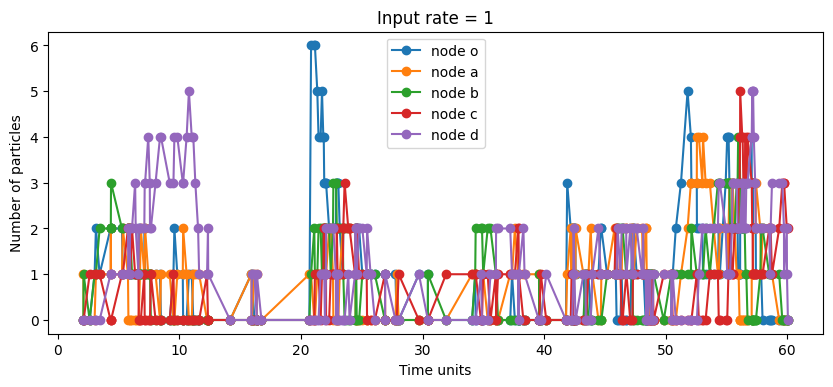

In [ ]:
input_rate = 1
pos1, t1, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos1[:end], t1[:end], input_rate)

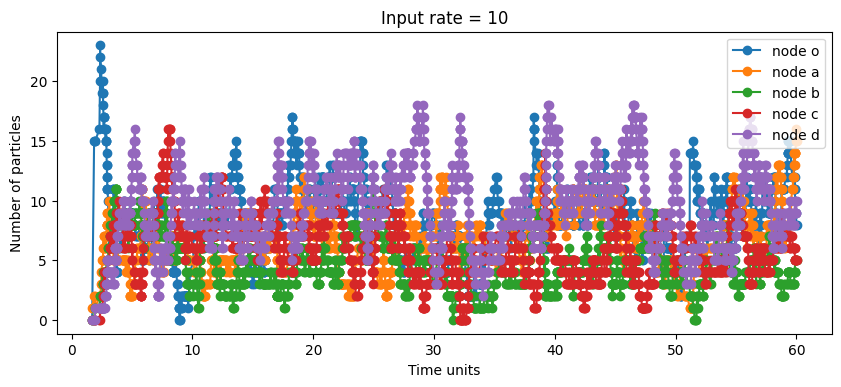

In [ ]:
input_rate = 10
pos3, t3, end = proportional_rate(input_rate)
plot_proportional_trajectories(pos3[:end], t3[:end], input_rate)

In this scenario we have two clock: one for the entrance of the particles with rate l=1 and one
global clock with rate proportional to the number of particles in the system. We keep an extra
node d’ for the particles exiting the system.
We simulate the system till we reach 60 time units. At every step we compare the cumulative
transition time of the entrance clock and the one of the global clock: we let ticks the clock with the
lower transition time.
For the simulation we set 4 different input rates: 1, 2, 5, 10.
We can see the system does not blow up, in particular, particles do not accumulate in node ‘o’
and they move around the graph. This is due to the proportional rate of the global clock, the more
particles are in the graph, the more the rate is higher. So each node is able to pass along its particles
to other nodes.

## Fixed rate

The rate of the Poisson clock of each node is fixed, and equal to one.
- Simulate the system for 60 time units and plot the evolution of number of particles in each node
over time.
- What is the largest input rate that the system can handle without blowing up? Why is this
different from the other case?

In [ ]:
def fixed_rate(input_rate):
  steps = 10000
  t_next = -np.log(np.random.rand())/w_star
  t_next_p = -np.log(np.random.rand())/input_rate
  pos = np.zeros((steps, nodes))
  pos[0,0] = 0
  transition_times = np.zeros(steps)
  transition_times_p = 0
  i = 0
  while transition_times[i-1] <= 60:
    # copy past state
    pos[i,:] = pos[i-1,:]
    while transition_times_p <= transition_times[i-1]:
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
    admissibles_nodes = np.argwhere(pos[i,:-1]!=0)

    if (admissibles_nodes.size==0):
      pos[i,0] = pos[i,0] + 1
      transition_times_p = transition_times_p + t_next_p
      t_next_p = -np.log(np.random.rand())/input_rate
      continue
    else:
      node = np.random.choice(admissibles_nodes.flatten())
    next_node = np.argwhere(Q_cum[node] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/(w_star)
    # node lose one particle
    pos[i,node] = pos[i,node]-1
    # next node gain one particle
    pos[i,next_node] = pos[i,next_node]+1
    i+=1
  return pos, transition_times, i

In [ ]:
def plot_fixed_trajectories(pos, transition_times, input_rate):
  fig = plt.figure(figsize=(10,6), dpi=100)
  ax = plt.subplot(111)
  array = ['o', 'a', 'b', 'c', 'd']
  for node in range(n_nodes-1):
    trajectory = pos[:,node]
    ax.plot(transition_times, trajectory, 'o-', label='node {}'.format(array[node]))
  ax.legend()
  ax.set_xlabel("Time units")
  ax.set_ylabel("Number of particles")
  ax.set_title("Input rate = {}".format(input_rate))

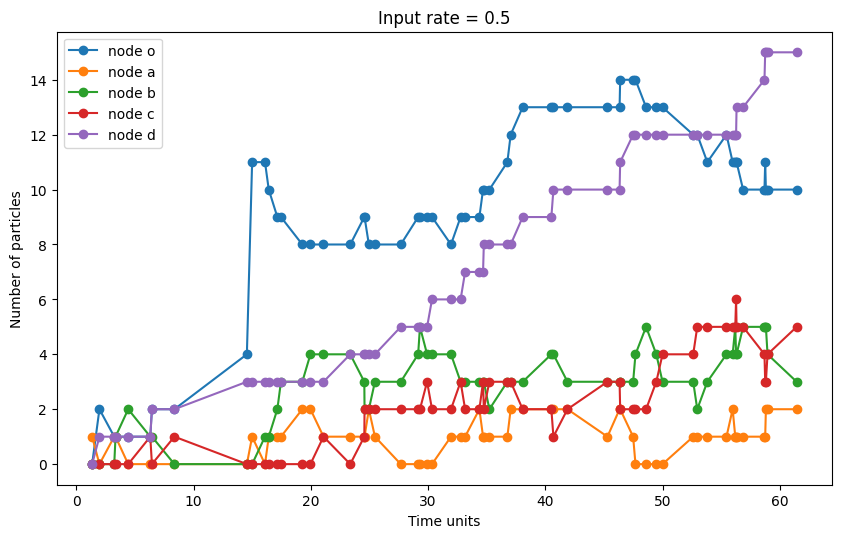

In [ ]:
input_rate = 0.5
pos1, t1, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos1[:end], t1[:end], input_rate)

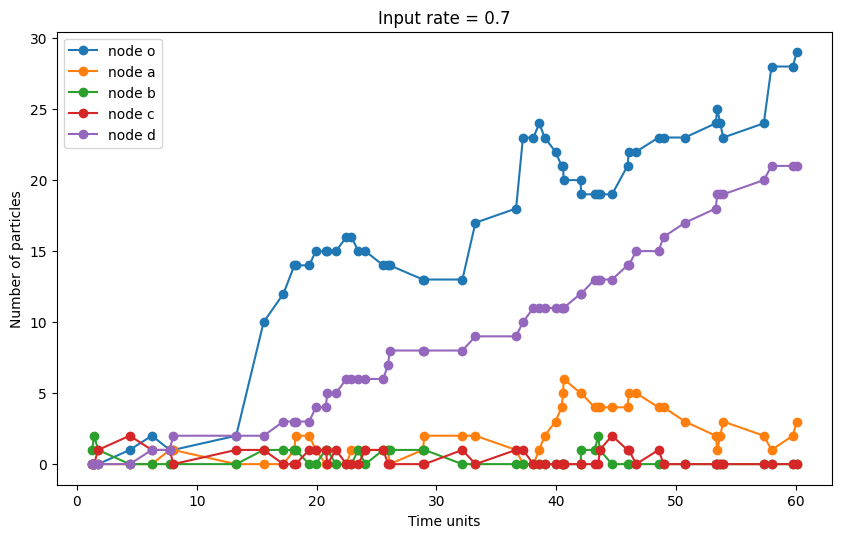

In [ ]:
input_rate = 0.7
pos2, t2, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos2[:end],t2[:end],input_rate)

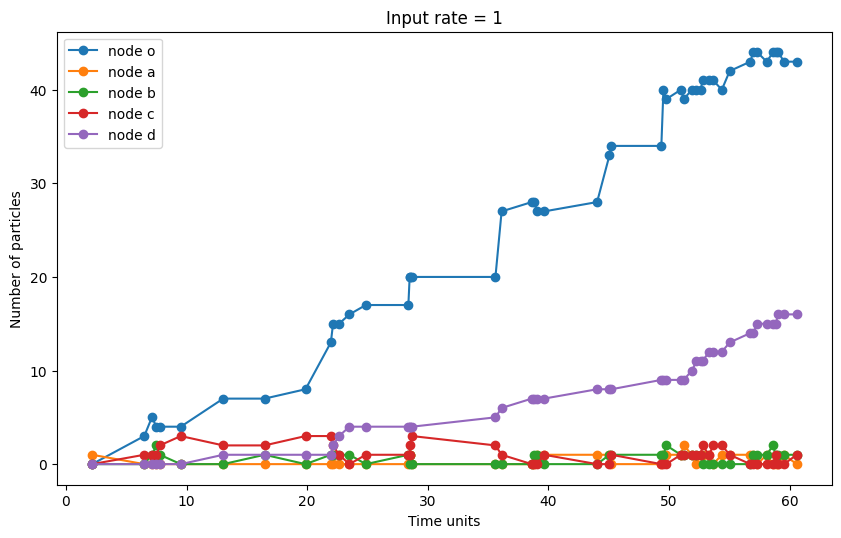

In [ ]:
input_rate = 1
pos3, t3, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos3[:end],t3[:end],input_rate)

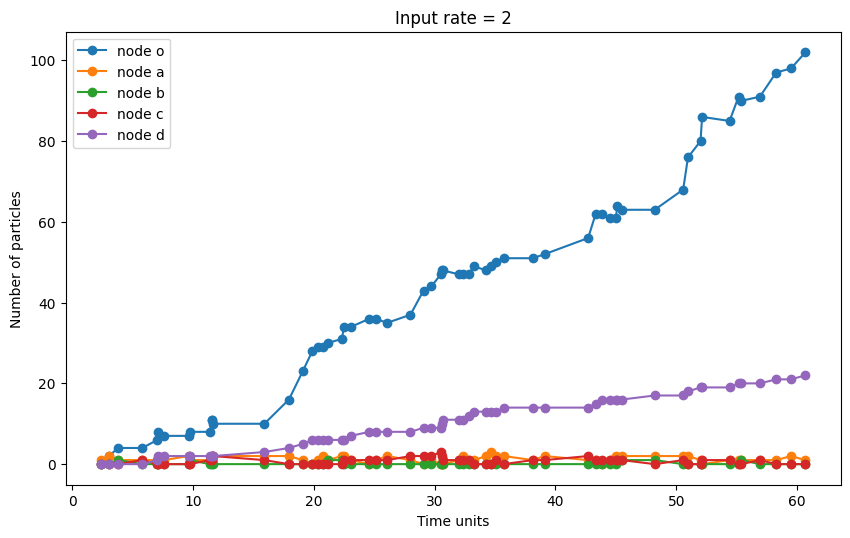

In [ ]:
input_rate = 2
pos4,t4, end = fixed_rate(input_rate)
plot_fixed_trajectories(pos4[:end] ,t4[:end] ,input_rate)

The difference between this simulation and the past one is the rate of the global clock: in this case
it is fixed and equals to 1 (wstar: the value of the maximum value from the vector w)
We simulate the rate case with 4 different input rates: 0.5, 0.7, 1, 2.
In this scenario we can clearly see that particles accumulate in node ‘o’ causing the blow-up. From
the plot we can identify the crucial input rate: 0.7.